# Toxic App - DSC478 Final Project

#### Authors: *Jeffrey Bocek, Xuyang Ji & Anna-Lisa Vu*

## Project Overview 

Unfortunately, having conversation about topics one cares about can be challenging under some scenerios, such as the threat of online abuse and harassment. Those insecure online environment not only causes many individuals to refrain from expressing themselves and seeking diverse opinions; but also has led to various platforms struggling to effectively facilitate discussions, resulting in many communities limiting or forcing shutting down user comment sections.


With a goal to foster healthier online communities by addressing the issue, our team worked on developing a Python application focuses on comment toxicity detection. The app can be used as a third-party library or extension for social media sites or public sites where users are allowed to leave comments. With various clustering and predictive models stored in the backend, the app allows users to detect the toxicity level of specific queries, and revise them for maintaining a more respectful online community. 

## Dataset Description
The provided dataset contains a large number of Wikipedia comments which have been labeled by human raters for toxic behavior, such as toxic, severe toxic, obscene, threat, insult and identity hate. 

#### Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import operator #for sorting 
from sklearn import preprocessing # for normalization 
from collections import Counter #finding the majority 

#Text Preprocessing 
import re # for number removal 
import string # for punctutation removal 

import nltk 
## for stopword removal
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords= stopwords.words('english')
## lemmatization 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer= WordNetLemmatizer()
from nltk.tokenize import word_tokenize

import pickle  #save variables to file

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lisasaurus01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lisasaurus01/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lisasaurus01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
train_df = pd.read_csv('train.csv')
test_comments = pd.read_csv('test.csv')
test_lab= pd.read_csv('test_labels.csv',header=0, na_values=-1)
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
test_df = pd.merge(test_comments, test_lab, on="id")
test_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,NaN,NaN,NaN,NaN,NaN,NaN
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,NaN,NaN,NaN,NaN,NaN,NaN
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",NaN,NaN,NaN,NaN,NaN,NaN


#### Class Imbalance 
The dataset comprises 159,571 comments from Wikipedia, with each comment consisting of a string data input feature and six labels that categorize the comment as toxic, severe_toxic, obscene, threat, insult, or identity_hate. The following figure shows how these labels are distributed throughout the dataset, including multilabelled data. Although there is no missing value in the training dataset; however, based on the fact that the mean values are extremely low, it can be inferred that the majority of the comments are likely to be clean/non-toxic comments. In other words, the toxicity is not evenly distributed across classes, and class imbalance is present. Upon investigation, the clean comment ratio in training set is 89.8%, while there are 58.2% of clean comments in the test set. 

The breakdown demonstrates that while most comments with other labels are also toxic, not all of them are. Only "severe_toxic" is clearly a subcategory of "toxic," which is reasonable to rule out labeling errors. The observation indicates that "toxic" is not a overseeing label, but rather a subcategory in the bigger context with considerable overlap with other labels. Regarding the issue of multi-labelling, it would most likely to pose difficulty to train a classifier on specific labels in the raw dataset due to overlapping. The ambiguity surrounding the label assignments and the absence of clear explanations is the reason why we opted to use aggregate labels of general toxicity levels, called "non_toxic", "mild_toxicity", "toxic", and "severe-toxic" as the targets going forwards. 

In [7]:
# Toxic vs. clean comment 
clean_comm= (train_df.iloc[:,2:].sum(axis=1)==0).sum(axis=0)
clean_test= len(test_lab[test_lab.isna().any(axis=1)])
print("The clean comment ratio in training set is:",(round(clean_comm/len(train_df),3)))
print("The clean comment ratio in test set is:",(round(clean_test/len(test_lab),3)))

The clean comment ratio in training set is: 0.898
The clean comment ratio in test set is: 0.582


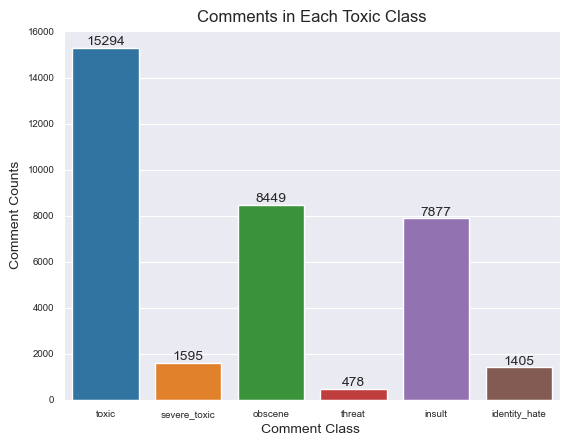

In [8]:
#Ratio of comments in each toxic class

categories= list(train_df.columns.values[2:])
                 
counts=[]
for category in categories:
    count=train_df[category].sum()
    ratio= round(count/len(train_df),3)
    counts.append((category,count,ratio))
category_stat = pd.DataFrame(counts, columns=["Class","Counts","Percentage"])
category_stat
ax= sns.barplot(x="Class",y="Counts",data=category_stat)
ax.bar_label(ax.containers[0])
plt.title("Comments in Each Toxic Class")
plt.ylabel('Comment Counts')
plt.xlabel('Comment Class ')
ax.tick_params(labelsize=7)

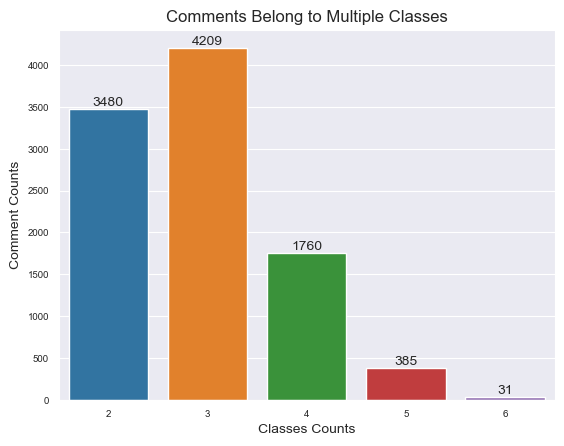

In [9]:
#Comments belong to multiple classes by getting rowSums 
multiClass_comm= train_df.iloc[:,2:].sum(axis=1).value_counts()
multiClass= multiClass_comm[multiClass_comm.index>1]
ax=sns.barplot(x=multiClass.index, y=multiClass.values)
ax.bar_label(ax.containers[0])
plt.title("Comments Belong to Multiple Classes")
plt.ylabel('Comment Counts')
plt.xlabel('Classes Counts')
ax.tick_params(labelsize=7)
plt.show()

In [19]:
pd.options.mode.chained_assignment = None
def reconfigure_categories(train_df, test_lab):
    'add categories to df'

    def plot_df_distributions(df, position, chart_title):
        'make a bar chart of df distributions'
        target_column =list(df.columns[position:])
        labelC = df[target_column].sum()
        plt.figure(figsize=(10,7))
        ax = sns.barplot(x=labelC.index, y=labelC.values,dodge=False)
        ax.set_yscale('log')
        ax.tick_params(labelsize=7)
        plt.title(chart_title)
        for i in ax.containers:
            ax.bar_label(i,)
    
    def config_train(train_df, position):
        target_col = list(train_df.columns[position:])
        #fill toxic column of sever toxic comments with 1 
        train_df.loc[train_df['severe_toxic']==1,'toxic'] =1

        # non-toxic comments are identified when all target_col value is 0. New column has been created,
        # if value of 1 then the comment is nontoxic
        train_df['non_toxic'] = 1-train_df[target_col].max(axis=1)

        # Since labels nested under each other in some cases, comments with toxicity defined are identified
        # with new column
        train_df['toxicity_defined'] = train_df[['insult', 'obscene', 'identity_hate', 'threat']].max(axis=1)

        # New toxic_undefined column for toxic comments but with no characteristic
        train_df['toxicity_undefined'] = 0  # initiziling all value of 0
        # for each comment that's not toxicity defined but labelled as toxic, labeled them as 1 in new column
        train_df.loc[(train_df['toxicity_defined'] == 0) & (train_df['toxic'] == 1), 'toxicity_undefined'] = 1

        # New mild_toxicity column for comment with toxicity defined but not labeled as toxic/severe toxic
        train_df['mild_toxicity'] = 0
        train_df.loc[(train_df['toxicity_defined'] == 1) & (train_df['toxic'] == 0) & (train_df['severe_toxic'] == 0),
                'mild_toxicity'] = 1

        #Now, we would create one variable including 4 levels:
        # level 0: Non-toxic comment (6% of the original dataset)
        # level 1: Mild_toxicity
        # level 2: Toxic (since all severe toxic comment are labeled as 1 in toxic comment, they are removed)
        # level 3: severe_toxic

        train_df['toxicity_level']=0 #initializing a column of 0
        train_df.loc[(train_df['non_toxic']==1),'toxicity_level']=1
        train_df.loc[(train_df['mild_toxicity']==1),'toxicity_level']=2
        train_df.loc[(train_df['toxic']==1)& (train_df['severe_toxic']==0),'toxicity_level']=3
        train_df.loc[(train_df['severe_toxic']==1), 'toxicity_level']=4

        #drop rows with toxicity level undefined
        train_df= train_df[train_df['toxicity_level']!= 0]

        #make sure the toxic comments does not include severe toxic comments
        train_df.loc[train_df['severe_toxic'] == 1, 'toxic'] = 0

        #train_df = train_df[train_df.toxicity_level !=2]
        #train_df['toxicity_level'] = train_df['toxicity_level'].replace([3,4], [2,3])
        #train_df = train_df.drop(columns=['mild_toxicity'])
        #print(train_df['toxicity_level'].value_counts())

        return train_df

    def config_test_lab(test_lab, position):
        test_lab = test_lab[~test_lab.isnull().any(axis=1)]
        target_col = list(test_lab.columns[position:])
        #fill toxic column of sever toxic comments with 1 
        test_lab.loc[test_lab['severe_toxic']==1,'toxic'] =1

        # non-toxic comments are identified when all target_col value is 0. New column has been created,
        # if value of 1 then the comment is nontoxic
        test_lab['non_toxic'] = 1-test_lab[target_col].max(axis=1)

        # Since labels nested under each other in some cases, comments with toxicity defined are identified
        # with new column
        test_lab['toxicity_defined'] = test_lab[['insult', 'obscene', 'identity_hate', 'threat']].max(axis=1)

        # New toxic_undefined column for toxic comments but with no characteristic
        test_lab['toxicity_undefined'] = 0  # initiziling all value of 0
        # for each comment that's not toxicity defined but labelled as toxic, labeled them as 1 in new column
        test_lab.loc[(test_lab['toxicity_defined'] == 0) & (test_lab['toxic'] == 1), 'toxicity_undefined'] = 1

        # New mild_toxicity column for comment with toxicity defined but not labeled as toxic/severe toxic
        test_lab['mild_toxicity'] = 0
        test_lab.loc[(test_lab['toxicity_defined'] == 1) & (test_lab['toxic'] == 0) & (test_lab['severe_toxic'] == 0),
                'mild_toxicity'] = 1

        #Now, we would create one variable including 4 levels:
        # level 0: Non-toxic comment
        # level 1: Mild_toxicity
        # level 2: Toxic (since all severe toxic comment are labeled as 1 in toxic comment, they are removed)
        # level 3: severe_toxic

        test_lab['toxicity_level']=0 #initializing a column of 0
        test_lab.loc[(test_lab['non_toxic']==1),'toxicity_level']=1
        test_lab.loc[(test_lab['mild_toxicity']==1),'toxicity_level']=2
        test_lab.loc[(test_lab['toxic']==1)& (test_lab['severe_toxic']==0),'toxicity_level']=3
        test_lab.loc[(test_lab['severe_toxic']==1), 'toxicity_level']=4

        #drop rows with toxicity level undefined
        test_lab= test_lab[test_lab['toxicity_level']!= 0]

        #make sure the toxic comments does not include severe toxic comments
        test_lab.loc[test_lab['severe_toxic'] == 1, 'toxic'] = 0

        #test_lab = test_lab[test_lab.toxicity_level !=2]
        #test_lab['toxicity_level'] = test_lab['toxicity_level'].replace([3,4], [2,3])
        #test_lab = test_lab.drop(columns=['mild_toxicity'])
        #print(test_lab['toxicity_level'].value_counts())
        return test_lab
 
    train_df = config_train(train_df, 2)
    test_lab = config_test_lab(test_lab, 2)

    plot_df_distributions(train_df, 2, "Training Data Class Distribution")
    plot_df_distributions(test_lab, 2, "Test Data Class Distribution")
    
    return train_df, test_lab

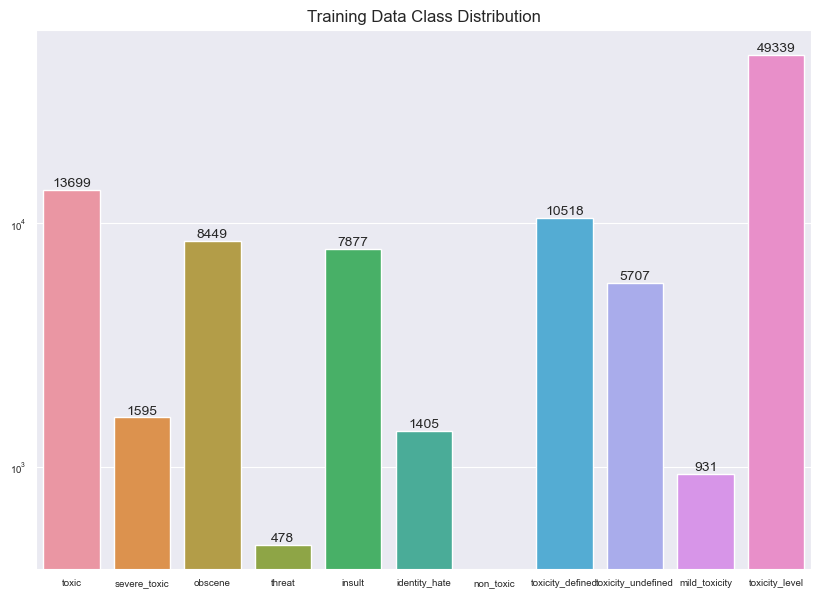

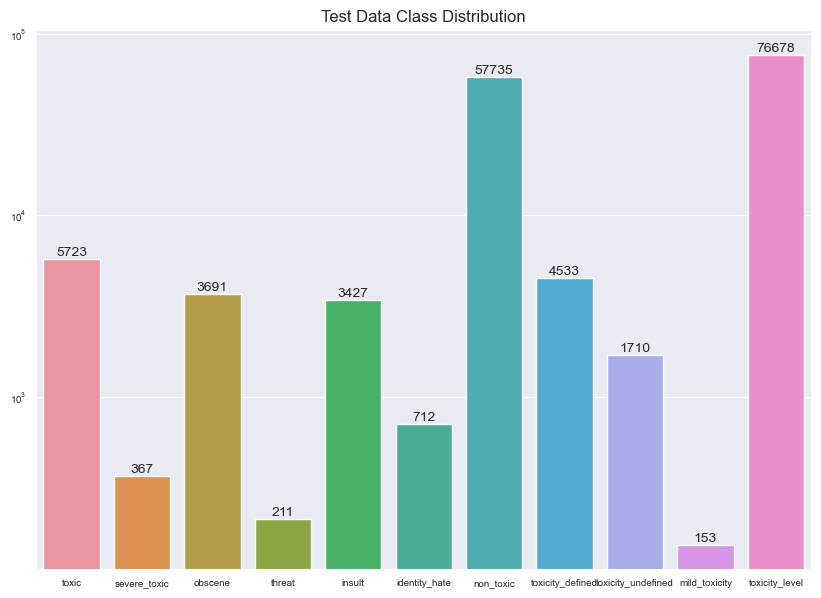

In [20]:
train_df, test_lab = reconfigure_categories(train_df, test_df)

In [22]:
def filter_df(train_df, test_lab):
    'create updated dataframe'
    train_df = train_df[['comment_text','non_toxic', 'overall_toxic']]
    test_lab = test_lab[['non_toxic', 'overall_toxic']]
    return train_df, test_lab

### Comment Length 
Looking at the histoplot for comment length differences between clean and toxic comments, clean comments tend to be approximately one-fourth longer than toxic comments on average.  Upon examining random samples, it becomes apparent that many clean comments consist of long and well-crafted responses. 

In [ ]:
comm= train_df[train_df.iloc[:,2:].sum(axis=1)==0]["comment_text"].str.split().apply(len)
toxic_comm= train_df[train_df.iloc[:,2:].sum(axis=1)!=0]["comment_text"].str.split().apply(len)
plt.hist([comm, toxic_comm], bins = 40, color =('c','m'), label=("Clean Comment", "Toxic Comment"))
plt.legend(loc='best')
plt.title("Distribution for Comment Lengths")
plt.xlim(0,600)
plt.xlabel("Word Counts")
plt.ylabel("Comment Density")
plt.show()

In [ ]:
def train_subsample_df(train_df, nontox_frac, tox_frac):
    'take a subsample of the dataframe based on a fractions of the distributions'

    nonToxic= train_df[['comment_text']].sample(frac = nontox_frac, random_state = 961)
    toxic = train_df[['comment_text']].sample(frac = tox_frac, random_state = 961)
    train_df = nonToxic.append(toxic)

    return train_df

def test_lab_subsample_df(test_lab, nontox_frac, tox_frac):
    'take a subsample of the dataframe based on a fractions of the distributions'

    nonToxic= test_lab['non_toxic'].sample(frac = nontox_frac, random_state = 961)
    toxic = test_lab['overall_toxic'].sample(frac = tox_frac, random_state = 961)
    test_lab = nonToxic.append(toxic)
    return test_lab


In [ ]:
# 1 - 0.01
# 2 -
# 3 - 0.10
# 4
def get_subsample(data, nontox_frac, toxic_frac, severetoxic_frac, chart_title):
    data=data[['comment_text', 'non_toxic','toxic','severe_toxic','toxicity_level']]

    non_toxic= data[data['toxicity_level']==1].sample(frac=nontox_frac,random_state=961)
    #print("Non toxic shape:"+str(nonToxic.shape))

    toxic= data[data['toxicity_level']==2].sample(frac=toxic_frac,random_state=961)
    #print("Toxic shape:"+str(nonToxic.shape))

    severe_toxic = data[data['toxicity_level']==3].sample(frac=severetoxic_frac,random_state=961)
    #print("Sever Toxic shape:"+str(toxic.shape))

    data = non_toxic.append(toxic).append(severe_toxic)
    print(data[['toxicity_level']].value_counts())

    #make sure the toxic comments does not include severe toxic comments
    data.loc[data['severe_toxic'] == 1, 'toxic'] = 0

    target= list(data.columns.drop(['comment_text','toxicity_level']))
    label= data[target].sum()
    plt.figure(figsize=(5,5))
    ax = sns.barplot(x=label.index, y=label.values)
    ax.tick_params(labelsize=7)
    plt.title(chart_title)
    for i in ax.containers:
        ax.bar_label(i,)

    return data

### Text Preprocessing 

The diversity and vastness of social media comments make it difficult to comprehend and capture the underlying trends and characteristics for comments with different toxicity levels. In details, keeping all words makes the dimensionality of each text extremely high, which makes classification more challenging. However, properly preprocessing the data, by reducing noise in the text, may improve classifier performance and speed up the classification process, thereby facilitating real-time sentiment analysis. Hence,in order to conduct data mining on online opinion data, the text preprocessing steps involve several stages, including removal of punctuation, lowering the text, removal of white spaces, stemming, removing stop words, handling negation, and finally tokenization and lemmatization. 

In [ ]:
#Removing punctuations'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punc(comment):
    nonPunc="".join([letter for letter in comment if letter not in string.punctuation])
    return nonPunc

#Lowering the text
def toLower(comment):
    return comment.lower()

#Removing numbers 
def replace_numbers(comment):
    """Replace all interger occurrences in 
    list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', comment)

#Removing whitespaces
def remove_space(comment):
    return comment.strip()

#Tokenization
def text2word(comment):
    return word_tokenize(comment)

#Removing Stop words
def remove_stopW(words,stopWords):
    return [word for word in words if word not in stopWords]

#Lemmatization
def lematizer(words):
    lemmatizer = WordNetLemmatizer()
    lemm_comm= [lemmatizer.lemmatize(word) for word in words]
    return lemm_comm

def lematizer_verb(words):
    lemmatizer = WordNetLemmatizer()
    lemm_comm= [lemmatizer.lemmatize(word,"v") for word in words]
    return lemm_comm


def clean_comment(comment):
    comment= remove_punc(comment)
    comment= toLower(comment)
    comment= replace_numbers(comment)
    comment= remove_space(comment)
    words=text2word(comment)
    words=remove_stopW(words,stopWords)
    words=lematizer(words)
    words=lematizer_verb(words)
    
    return ' '.join(words)

In [ ]:
def clean_comments(train_df, test_df):
    'clean comments in dataframes'

    train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean_comment(x))
    test_df['comment_text'] = test_df['comment_text'].apply(lambda x: clean_comment(x))
    return train_df, test_df

In [ ]:
def reset_index(df):
    'reset index of df'

    df= df.reset_index(drop=True)
    return df

In [ ]:
def store_dfs(file_name, dfs):
    'store dataframes to file'

    clean_data = dfs
    with open(file_name, 'wb') as my_file_object:
        pickle.dump(clean_data, my_file_object)

### Final Set of Steps to Clean Data and Reduce Data Sets

In [ ]:
# the fractions below correspond to each toxicity level.  They can be adjusted accordingly.
train_df = get_subsample(train_df, 0.01, .10, 1.0, "Distribution of Training Data")
test_df = get_subsample(test_df, 0.01, .10, 1.0, "Distribution of Testing Data")

print('Train df shape = ' +str(train_df.shape))
print('Test df shape = ' +str(test_df.shape))

train_df, test_df = clean_comments(train_df, test_df)
#test
#train_df["comment_text"].iloc[2]

for df in [train_df, test_df]:
   reset_index(df)

#can input file name to correspond with percent of distributions
store_dfs('clean_data1.p', [train_df, test_df])


In [ ]:
train_df["comment_text"].iloc[2]

In [ ]:
test_df["comment_text"].iloc[2]

In [ ]:
test_lab.head()